
Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [63]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from plotnine import *

In [3]:

from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, roc_curve
from plotnine import *


In [2]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
ha.head(5)

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


In [30]:
X = ha.drop(columns = ["cp"])
y = ha["cp"]

cat_cols = ['sex', 'output', 'restecg']
num_cols = ['age', 'trtbps', 'chol', 'thalach']

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

ct = ColumnTransformer([('dummify', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_cols),
                        ('standardize', StandardScaler(), num_cols)],
                         remainder='drop').set_output(transform="pandas")

**A feature selection function**

In [31]:
from itertools import combinations # to get all possible combinations of features

def get_best_features(model_name, X, y, num_cols, cat_cols, param=None):

  if model_name == "knn":
    model = KNeighborsClassifier(n_neighbors=param)
  elif model_name == "dt":
    model = DecisionTreeClassifier(max_depth=param)
  elif model_name == "logreg":
    model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

  rows = []
  predictors = num_cols + cat_cols

  for var in range(1, len(predictors) + 1):
    for combination in combinations(predictors, var):
      combination = list(combination)

      num_in = [c for c in num_cols if c in combination]
      cat_in = [c for c in cat_cols if c in combination]

      ct = ColumnTransformer([('dummify', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_in),
                        ('standardize', StandardScaler(), num_in)],
                         remainder='drop')

      pipe = Pipeline([('preprocess', ct),
                       (model_name, model)])

      cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

      score = cross_val_score(pipe, X[combination], y, cv=cv, scoring="accuracy").mean()

      rows.append({"features": combination, "accuracy": score})

  final = pd.DataFrame(rows).sort_values("accuracy", ascending=False).reset_index(drop=True)

  return final

In [40]:
def make_ct(cat_var=None, num_var=None):

  steps = []

  if cat_var is not None:
    step_cat = ("dummify",
                 OneHotEncoder(sparse_output = False, handle_unknown='ignore'), cat_var)
    steps.append(step_cat)

  if num_var is not None:
    step_num = ("standardize",
                 StandardScaler(), num_var)
    steps.append(step_num)


  ct = ColumnTransformer(steps, remainder = "drop")

  return ct

## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


### **kNN**

In [41]:
get_best_features("knn", X, y, num_cols=num_cols, cat_cols=cat_cols, param=5).head(3)

,features,accuracy
0,"[restecg, trtbps, sex, output]",0.578721
1,"[trtbps, sex, output]",0.549966
2,"[restecg, trtbps, output]",0.542424


In [47]:
cat_cols = ['sex', 'output']
num_cols = ['restecg', 'trtbps']

ct_knn = make_ct(cat_cols, num_cols).set_output(transform="pandas")

knn_model = Pipeline([("scale", ct_knn),
                      ("model", KNeighborsClassifier(n_neighbors=5))])

knn_model.fit(X, y)

cv_scores = cross_val_score(knn_model, X, y, cv = 5, scoring = "accuracy")
cv_scores.mean()

np.float64(0.5279461279461279)

### **Decision Tree**

[Text(0.5, 0.875, 'output <= -0.07\ngini = 0.661\nsamples = 273\nvalue = [128, 44, 81, 20]'),
 Text(0.25, 0.625, 'thalach <= -0.213\ngini = 0.425\nsamples = 127\nvalue = [94, 8, 18, 7]'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'chol <= -1.703\ngini = 0.283\nsamples = 75\nvalue = [63, 3, 7, 2]'),
 Text(0.0625, 0.125, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1, 0]'),
 Text(0.1875, 0.125, 'gini = 0.266\nsamples = 74\nvalue = [63, 3, 6, 2]'),
 Text(0.375, 0.375, 'thalach <= 0.132\ngini = 0.581\nsamples = 52\nvalue = [31, 5, 11, 5]'),
 Text(0.3125, 0.125, 'gini = 0.627\nsamples = 13\nvalue = [5, 1, 6, 1]'),
 Text(0.4375, 0.125, 'gini = 0.518\nsamples = 39\nvalue = [26, 4, 5, 4]'),
 Text(0.75, 0.625, 'trtbps <= 0.645\ngini = 0.691\nsamples = 146\nvalue = [34, 36, 63, 13]'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'thalach <= 0.132\ngini = 0.674\nsamples = 122\nvalue = [31, 34, 52, 5]'),
 Text(0.5625, 0.125, 'gini = 0.641\nsamples = 40\nvalue = [17, 5, 16, 2]'),
 Text(0.

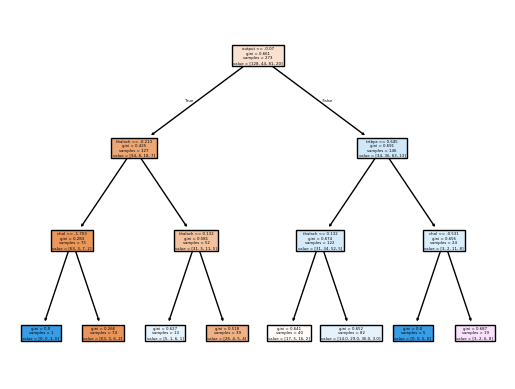

In [59]:
dt_model =Pipeline([("scale", StandardScaler()),
                    ("model", DecisionTreeClassifier(max_depth=3))])

dt_model.fit(X, y)
plot_tree(dt_model.named_steps["model"], feature_names=["age", "sex", "trtbps", "chol", "restecg", "thalach", "output"], filled=True)

In [56]:
cross_val_score(dt_model, X, y, cv = 5, scoring = "accuracy").mean()

np.float64(0.5311784511784511)

### **LDA**

In [62]:
lda_ct = make_ct(cat_var=cat_cols, num_var=num_cols)

lda_model = Pipeline([("prep", lda_ct),
                      ("lda", LinearDiscriminantAnalysis())])

lda_model_fitted = lda_model.fit(X, y)

cross_val_score(lda_model, X, y, cv = 5, scoring = "accuracy").mean()

np.float64(0.5497643097643097)

## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

In [94]:
ha2 = ha.copy()
ha2["cp_is_3"] = np.where(ha2["cp"] == 3, 1, 0)
ha2["cp_is_2"] = np.where(ha2["cp"] == 2, 1, 0)
ha2["cp_is_1"] = np.where(ha2["cp"] == 1, 1, 0)
ha2["cp_is_0"] = np.where(ha2["cp"] == 0, 1, 0)
ha2["cp"] = ha2["cp"].astype("str")
ha2.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output,cp_is_3,cp_is_2,cp_is_1,cp_is_0
0,63,1,3,145,233,0,150,1,1,0,0,0
1,37,1,2,130,250,1,187,1,0,1,0,0
2,56,1,1,120,236,1,178,1,0,0,1,0
3,57,0,0,120,354,1,163,1,0,0,0,1
4,57,1,0,140,192,1,148,1,0,0,0,1


In [95]:
X = ha2.drop(columns = ["cp", "cp_is_3", "cp_is_2", "cp_is_1", "cp_is_0"])
y3 = ha2["cp_is_3"]
y2 = ha2["cp_is_2"]
y1 = ha2["cp_is_1"]
y0 = ha2["cp_is_0"]

cat_cols = ['sex', 'output', 'restecg']
num_cols = ['age', 'trtbps', 'chol', 'thalach']

ct_log = make_ct(cat_cols, num_cols).set_output(transform="pandas")

logreg_pipe = Pipeline([("preprocess", ct_log),
                        ("model", LogisticRegression())])

In [97]:
logreg_pipe.fit(X, y3)

prec = cross_val_score(logreg_pipe, X, y3, cv=5, scoring="precision").mean()
recall = cross_val_score(logreg_pipe, X, y3, cv=5, scoring="recall").mean()
f1 = cross_val_score(logreg_pipe, X, y3, cv=5, scoring="f1").mean()

print("Precision:", prec)
print("Recall:", recall)
print("F1 Score:", f1)

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


Precision: 0.0
Recall: 0.0
F1 Score: 0.0


In [98]:
logreg_pipe.fit(X, y2)

prec = cross_val_score(logreg_pipe, X, y2, cv=5, scoring="precision").mean()
recall = cross_val_score(logreg_pipe, X, y2, cv=5, scoring="recall").mean()
f1 = cross_val_score(logreg_pipe, X, y2, cv=5, scoring="f1").mean()

print("Precision:", prec)
print("Recall:", recall)
print("F1 Score:", f1)

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


Precision: 0.2914285714285714
Recall: 0.17426470588235293
F1 Score: 0.13725490196078433


In [99]:
logreg_pipe.fit(X, y1)

prec = cross_val_score(logreg_pipe, X, y1, cv=5, scoring="precision").mean()
recall = cross_val_score(logreg_pipe, X, y1, cv=5, scoring="recall").mean()
f1 = cross_val_score(logreg_pipe, X, y1, cv=5, scoring="f1").mean()

print("Precision:", prec)
print("Recall:", recall)
print("F1 Score:", f1)

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


Precision: 0.0
Recall: 0.0
F1 Score: 0.0


In [101]:
logreg_pipe.fit(X, y0)

prec = cross_val_score(logreg_pipe, X, y0, cv=5, scoring="precision").mean()
recall = cross_val_score(logreg_pipe, X, y0, cv=5, scoring="recall").mean()
f1 = cross_val_score(logreg_pipe, X, y0, cv=5, scoring="f1").mean()

print("Precision:", prec)
print("Recall:", recall)
print("F1 Score:", f1)

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


Precision: 0.6256623359164193
Recall: 0.7224615384615385
F1 Score: 0.6492580932322991


OvR was best at predicting category 1.

## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

In [106]:
cat_cols = ['sex', 'output', 'restecg']
num_cols = ['age', 'trtbps', 'chol', 'thalach']

ct_log = make_ct(cat_cols, num_cols).set_output(transform="pandas")

In [109]:
ha_01 = ha[(ha["cp"] == 0) | (ha["cp"] == 1)]
ha_01["cp"] = ha_01["cp"].astype("str")
X = ha_01.drop(columns = ["cp"])
y = ha_01["cp"]

logreg_pipe = Pipeline([("preprocess", ct_log),
                        ("model", LogisticRegression())])

logreg_pipe.fit(X, y)
rocauc = cross_val_score(logreg_pipe, X, y, cv=5, scoring="roc_auc").mean()

print("ROC AUC:", rocauc)

/tmp/ipython-input-1976622437.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ROC AUC: 0.8379658119658119


In [111]:
ha_02 = ha[(ha["cp"] == 0) | (ha["cp"] == 2)]
ha_02["cp"] = ha_02["cp"].astype("str")
X = ha_02.drop(columns = ["cp"])
y = ha_02["cp"]

logreg_pipe = Pipeline([("preprocess", ct_log),
                        ("model", LogisticRegression())])

logreg_pipe.fit(X, y)
rocauc = cross_val_score(logreg_pipe, X, y, cv=5, scoring="roc_auc").mean()

print("ROC AUC:", rocauc)

ROC AUC: 0.7457341628959276


/tmp/ipython-input-3892616628.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [112]:
ha_03 = ha[(ha["cp"] == 0) | (ha["cp"] == 3)]
ha_03["cp"] = ha_03["cp"].astype("str")
X = ha_03.drop(columns = ["cp"])
y = ha_03["cp"]

logreg_pipe = Pipeline([("preprocess", ct_log),
                        ("model", LogisticRegression())])

logreg_pipe.fit(X, y)
rocauc = cross_val_score(logreg_pipe, X, y, cv=5, scoring="roc_auc").mean()

print("ROC AUC:", rocauc)

/tmp/ipython-input-2651146335.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ROC AUC: 0.7313076923076924


OvO was best at distinguishing category 0 from category 1.